In [55]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [56]:
# paths (on my laptop; cahnge for own paths)
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\train"
csv_file = r"C:\Users\chris\Downloads\eclipse-megamovie\train.csv"

# load csv without header
df = pd.read_csv(csv_file)

# sample
print(df.head())

# construct full image paths
df['path'] = df['image_id'].apply(lambda x: os.path.join(train_dir, x))


                                            image_id  label
0  0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0
1  00ade9976af2090eae8e6e5eed3096f12dc7235adb3c12...      0
2  ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0
3  eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0
4  fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0


In [57]:
def show_random_sift_keypoints(df, size=(512, 512)):
    sample = df.sample(1).iloc[0]
    image_path = sample['path']
    label = sample['label']
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # SIFT detector (contrastThreshold and edgeThreshold edited from defaults 0.04 and 10 respectively)
    sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=5)
    keypoints = sift.detect(gray, None)

    # draw keypoints
    img_kp = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"SIFT Keypoints (Label: {label}) - {len(keypoints)} keypoints")
    plt.show()

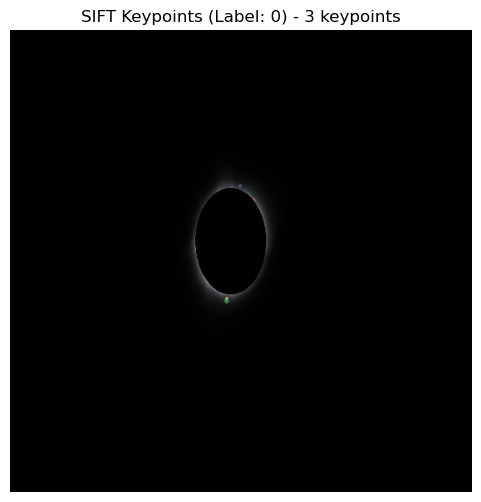

In [58]:
show_random_sift_keypoints(df)

In [59]:
# show n random images to visualize
def show_n_sift_keypoints(df, n=5, size=(512, 512)):
    samples = df.sample(n)
    plt.figure(figsize=(15, 15))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img = cv2.imread(row['path'])
        if img is None:
            continue
        img = cv2.resize(img, size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create(contrastThreshold=0.005, edgeThreshold=3)
        keypoints = sift.detect(gray, None)
        img_kp = cv2.drawKeypoints(
            img, keypoints, None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        plt.subplot(1, n, i+1)
        plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Label: {row['label']} | {len(keypoints)} kp")

    plt.tight_layout()
    plt.show()

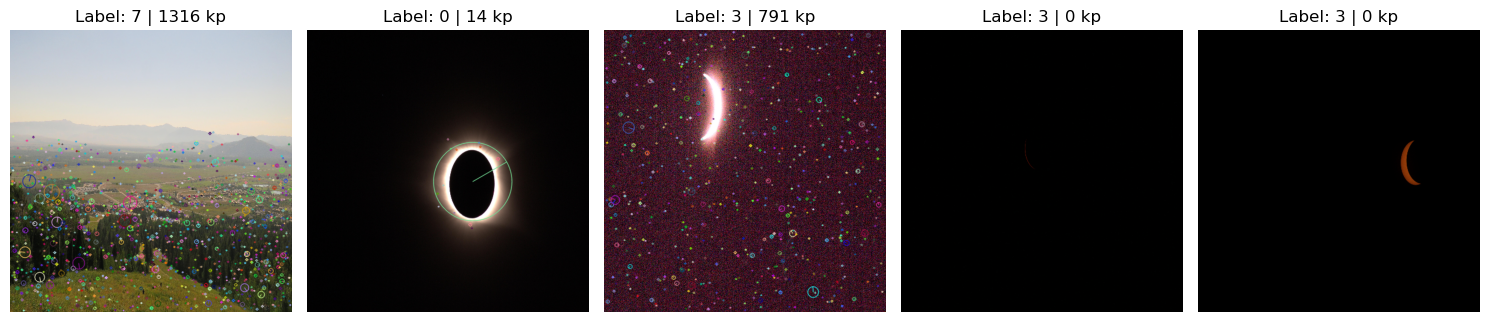

In [60]:
show_n_sift_keypoints(df)

In [63]:
def show_sift_keypoints_with_equalization(df, size=(512, 512)):
    sample = df.sample(1).iloc[0]
    image_path = sample['path']
    label = sample['label']
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # histogram equalization
    gray_eq = cv2.equalizeHist(gray)

    # orrrrrr
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    # gray_eq = clahe.apply(gray)
    
    # SIFT detector with enhanced contrast image
    sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10)
    keypoints = sift.detect(gray_eq, None)

    # draw keypoints
    img_kp = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"SIFT Keypoints with Equalization (Label: {label}) - {len(keypoints)} keypoints")
    plt.show()


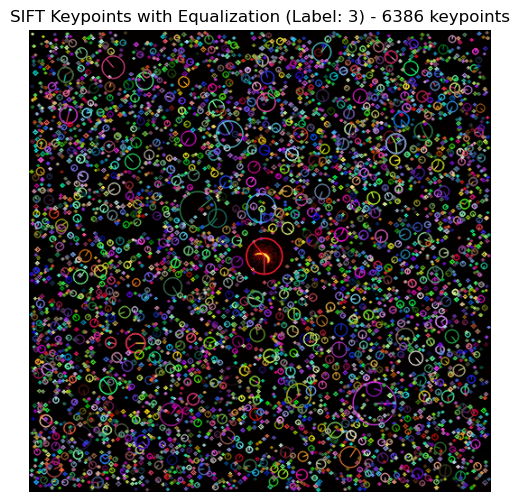

In [64]:
show_sift_keypoints_with_equalization(df)

In [65]:
def show_sift_keypoints_filtered(df, size=(512, 512)):
    sample = df.sample(1).iloc[0]
    image_path = sample['path']
    label = sample['label']
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    # gaussian blur to suppress noise
    gray_blurred = cv2.GaussianBlur(gray_eq, (3, 3), 0)

    # SIFT detector with less sensitivity to noise
    sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10)
    keypoints = sift.detect(gray_blurred, None)

    # filter out small keypoints
    keypoints = [kp for kp in keypoints if kp.size > 3]

    # draw keypoints on original image
    img_kp = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # original image
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Original Image (Label: {label})")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"SIFT Keypoints - {len(keypoints)} detected")

    plt.tight_layout()
    plt.show()

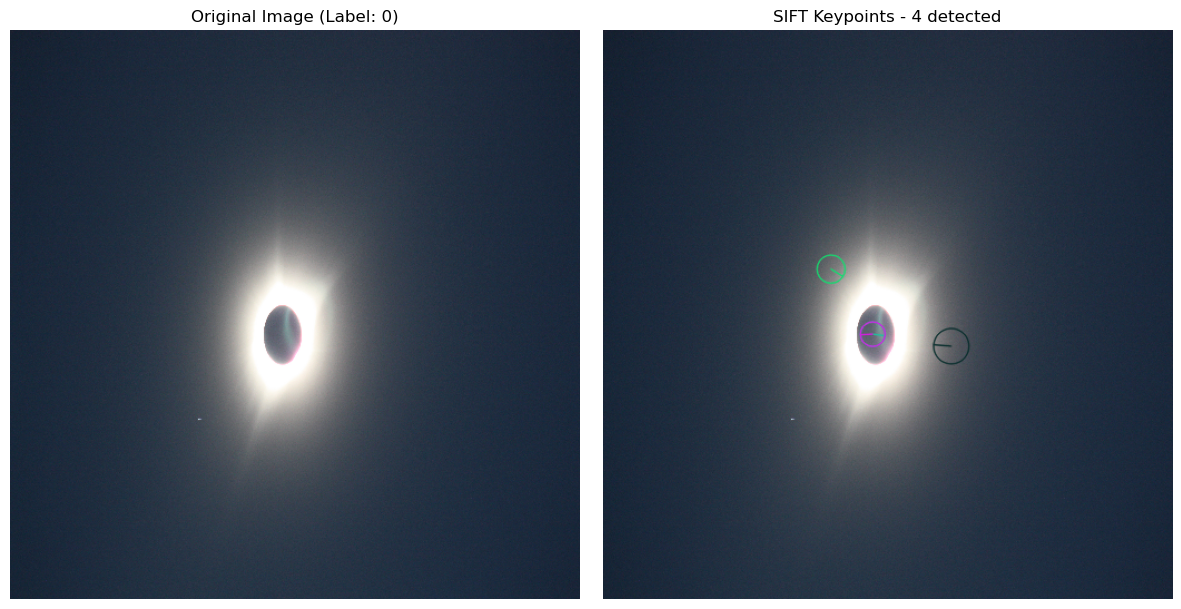

In [78]:
show_sift_keypoints_filtered(df)